# k-scheduling tests

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from random import sample, seed
from collections import defaultdict

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble
from qiskit.algorithms import amplitude_estimators, EstimationProblem
from qiskit.algorithms import IterativeAmplitudeEstimation as BaseIterativeAmplitudeEstimation

from algorithms import IterativeAmplitudeEstimation, ModifiedIterativeAmplitudeEstimation
from operators import *

In [2]:
# for setting a single amplitude, below automates this for arbirtrary numbers of amplitudes
n = 4
N = 2**n
k = N//2
marked = sample(range(N), k)

In [3]:
# Define the estimation problem and oracle function
def make_problems(n, marked):
    
    def good_state(state):
        bin_marked = [(n-len(bin(s))+2)*'0'+bin(s)[2:] for s in marked]
        return (state in bin_marked)

    problem = EstimationProblem(
        state_preparation=A(n),  # A operator
        grover_operator=Q(n, marked),  # Q operator
        objective_qubits=range(n),
        is_good_state=good_state  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )

    problem2 = EstimationProblem(
        state_preparation=A(n),  # A operator
        grover_operator=Q(n, marked),  # Q operator
        objective_qubits=range(n),
        is_good_state=good_state  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )
    
    return problem, problem2

In [4]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024

## IQAE: attempt exponential decay in the number of shots per iteration to account for deeper circuits.

In [5]:
# parameters for IQAE

# amplitudes
n = 5
k = 2**n

# epsilons
powers = range(2,7)
epsilons = [(1.0 / (10**power)) for power in powers]

# other
alpha = 0.05
confint_method = 'chernoff'
verbose = False

a: 1.0
Modified IAE estimations: [0.9999697023206886, 0.999999887379654, 0.9999999811099944, 0.9999999998529586, 0.9999999999990591]
Default IAE estimations: [0.9999695800124137, 0.9999980572858754, 0.9999999932681204, 0.9999999999744948, 0.9999999999983473]


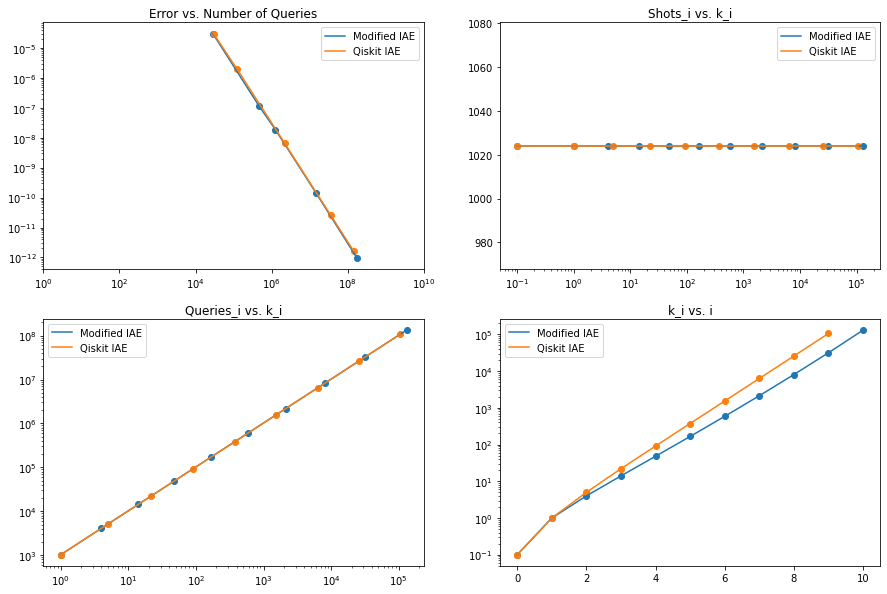

a: 0.5
Modified IAE estimations: [0.5000548953115449, 0.4999671846756163, 0.49999494665697175, 0.5000007348092486, 0.49999991051849874]
Default IAE estimations: [0.4997212392232571, 0.5001722011478438, 0.5000055894922149, 0.4999999424187108, 0.50000000707551]


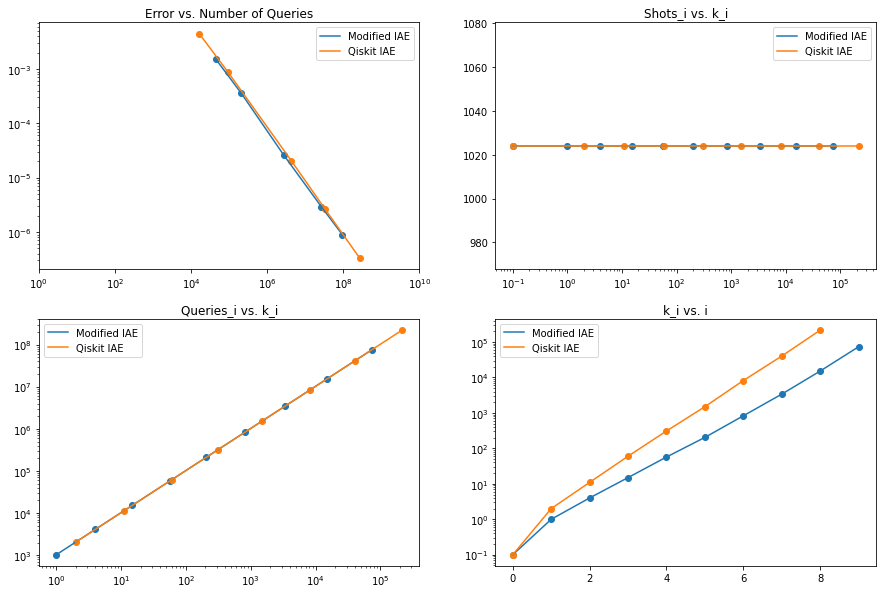

a: 0.25
Modified IAE estimations: [0.24995025933281517, 0.24999602308645186, 0.2500023247604633, 0.2500003901427794, 0.250000136174795]
Default IAE estimations: [0.24944070279028455, 0.25007423718746163, 0.2500004140913302, 0.2500005761817277, 0.24999996361976154]


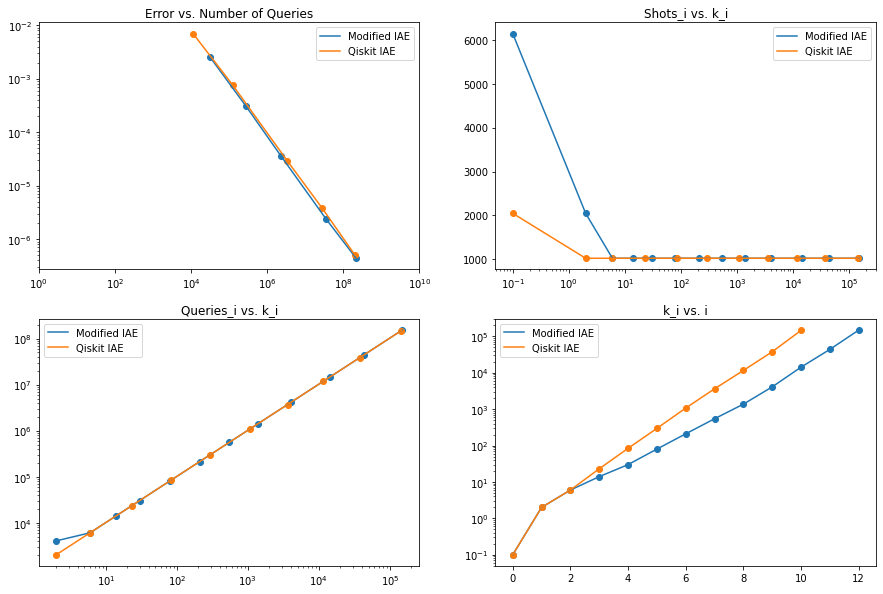

a: 0.125
Modified IAE estimations: [0.12384198200458896, 0.12498878600431476, 0.12499366468668713, 0.12500060126582266, 0.12499997410292249]
Default IAE estimations: [0.1232562291115933, 0.12496150413734644, 0.12499906451468956, 0.12500000929753166, 0.12500008179415178]


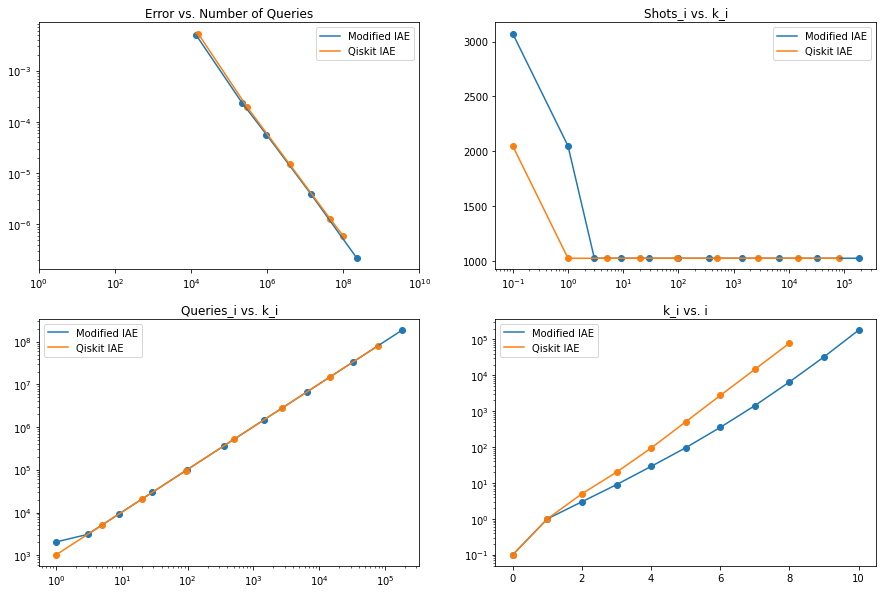

a: 0.0625
Modified IAE estimations: [0.062475119380340186, 0.06253143772192261, 0.06250137825147042, 0.06249986965046092, 0.06250004107748004]
Default IAE estimations: [0.06223997032526099, 0.06256201433444772, 0.062496268320003545, 0.06249975207576036, 0.06250009903586784]


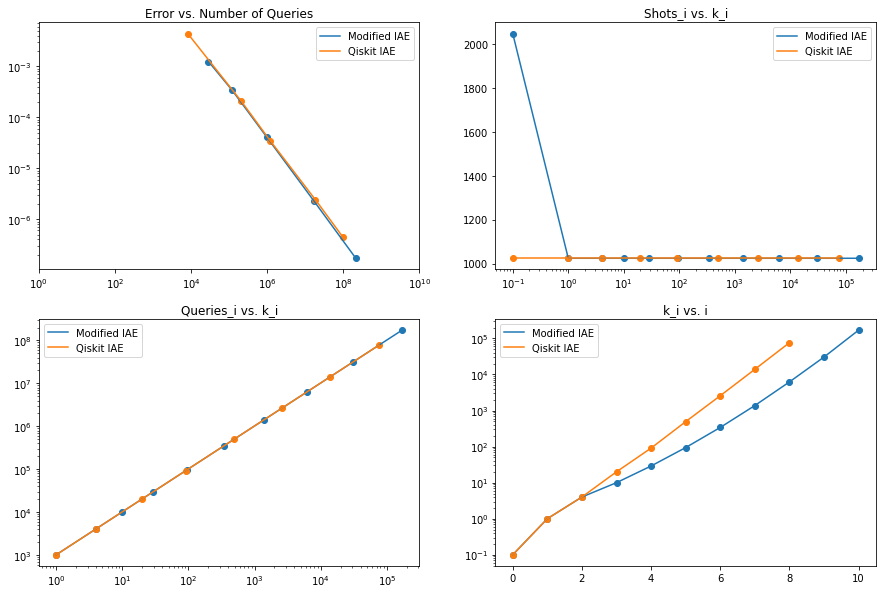

a: 0.03125
Modified IAE estimations: [0.0312973168960587, 0.03126629625527774, 0.03125107922628467, 0.03124999664144123, 0.03125000030249903]
Default IAE estimations: [0.031108342542403866, 0.031249328742959843, 0.03124985372997916, 0.0312500392796349, 0.0312500031514045]


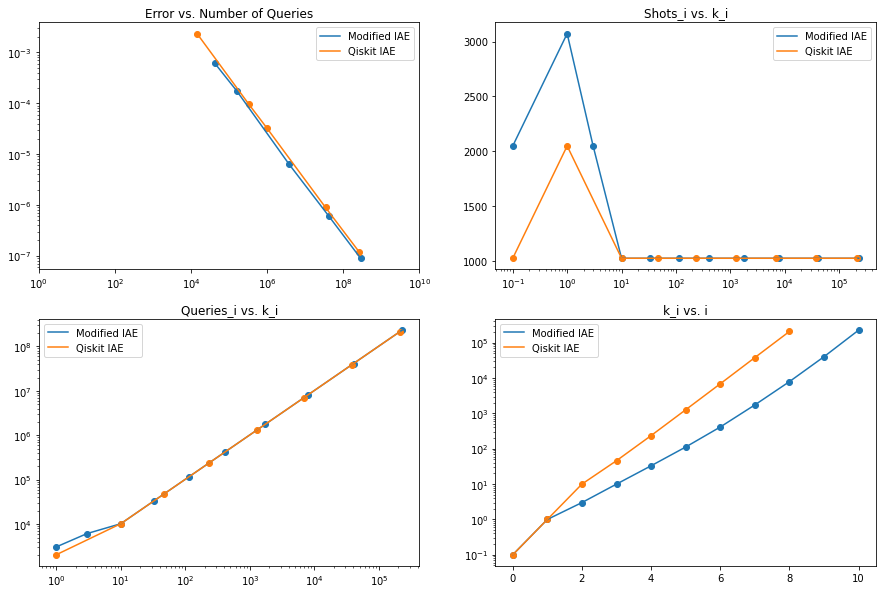

In [6]:
# stats recording
iae_epsilon = []
iae_nshots = []
miae_epsilon = []
miae_nshots = []

while k >= 1:
    
    # setup problems with specified N,k
    N = 2**n
    marked = sample(range(N), k)
    problem, problem2 = make_problems(n, marked)
    
    # execute experiments for each power
    miae_results = [] 
    iae_results = []
    
    for i, epsilon in enumerate(epsilons):
        if verbose:
            print('ε:',epsilon)
            
        MIAE = ModifiedIterativeAmplitudeEstimation(epsilon_target=epsilon, 
                                           alpha=alpha, 
                                           confint_method=confint_method, 
                                           quantum_instance=aer_sim)
        
        IAE = IterativeAmplitudeEstimation(epsilon_target=epsilon, 
                                                alpha=alpha, 
                                                confint_method=confint_method, 
                                                quantum_instance=aer_sim)
        
        # configure the number of shots this way and pray that it works
        MIAE._quantum_instance._run_config.shots = shots
        IAE._quantum_instance._run_config.shots = shots
        
        # for recording intermediate algo results
        state = defaultdict(dict)
        state2 = defaultdict(dict)
        
        miae_result = MIAE.estimate(problem,
                                    state=state,
                                    verbose=verbose)
        
        iae_result = IAE.estimate(problem2,
                                  state=state2,
                                  verbose=verbose)
        
        miae_results.append(miae_result)
        iae_results.append(iae_result)
        if verbose:
            print()
    
    # process results
    miae_epsilon_i = [(res.confidence_interval_processed[1] - res.confidence_interval_processed[0]) / 2 for res in miae_results]
    miae_nshots_i  = [res.num_oracle_queries for res in miae_results]

    iae_epsilon_i = [(res.confidence_interval_processed[1] - res.confidence_interval_processed[0]) / 2 for res in iae_results]
    iae_nshots_i  = [res.num_oracle_queries for res in iae_results]
    
    print('a:', k/N)
    print('Modified IAE estimations:', [res.estimation for res in miae_results])
    print('Default IAE estimations:', [res.estimation for res in iae_results])
    
    # graph k_i vs num_shots
    def process_state(state):
        if len(state) == 0: return [],[]
        round_shots = state['round_shots']
        queries = state['n_queries']
        shots_at_k0 = round_shots.pop(0)
        queries_at_k0 = queries.pop(0)
    
        k_i = [k for k in round_shots]
        queries_i = [queries[k] for k in k_i]
        shots_i = [shots_at_k0] + [round_shots[k] for k in k_i]
    
        k_i.insert(0, 0.1)
        
        return shots_i, queries_i, k_i
    
    mod_shots, mod_queries, mod_k = process_state(state)
    base_shots, base_queries, base_k = process_state(state2)

    fig,axs = plt.subplots(2,2,figsize=(15,10))
    
    # plot query complexity
    
    axs[0,0].set_yscale('log')
    axs[0,0].set_xscale('log')
    axs[0,0].set_xlim(1, 10**10)
    axs[0,0].set_title('Error vs. Number of Queries')
    
    axs[0,0].scatter(miae_nshots_i, miae_epsilon_i)
    axs[0,0].plot(miae_nshots_i, miae_epsilon_i)
    axs[0,0].scatter(iae_nshots_i, iae_epsilon_i)
    axs[0,0].plot(iae_nshots_i, iae_epsilon_i)
    
    axs[0,0].legend(['Modified IAE', 'Qiskit IAE'])
    
    # plots for shots vs k
    axs[0,1].set_xscale('log')
    axs[0,1].set_title('Shots_i vs. k_i')
    
    axs[0,1].plot(mod_k, mod_shots)
    axs[0,1].scatter(mod_k, mod_shots)
    axs[0,1].plot(base_k, base_shots)
    axs[0,1].scatter(base_k, base_shots)
    
    axs[0,1].legend(['Modified IAE', 'Qiskit IAE'])
    
    # plots for nqueries vs k
    axs[1,0].set_xscale('log')
    axs[1,0].set_yscale('log')
    axs[1,0].set_title('Queries_i vs. k_i')
    
    axs[1,0].plot(mod_k[1:], mod_queries)
    axs[1,0].scatter(mod_k[1:], mod_queries)
    axs[1,0].plot(base_k[1:], base_queries)
    axs[1,0].scatter(base_k[1:], base_queries)
    
    axs[1,0].legend(['Modified IAE', 'Qiskit IAE'])
    
    # plots for k
    axs[1,1].set_yscale('log')
    axs[1,1].set_title('k_i vs. i')
    
    axs[1,1].plot(mod_k)
    axs[1,1].scatter(range(len(mod_k)), mod_k)
    axs[1,1].plot(base_k)
    axs[1,1].scatter(range(len(base_k)), base_k)
    
    axs[1,1].legend(['Modified IAE', 'Qiskit IAE'])
    
    plt.show()
    
    # save results for epsilon vs nshots
    miae_nshots.append(miae_nshots_i)
    miae_epsilon.append(miae_epsilon_i)
    iae_nshots.append(iae_nshots_i)
    iae_epsilon.append(iae_epsilon_i)
    k //= 2
    
iae_nshots = np.array(iae_nshots)

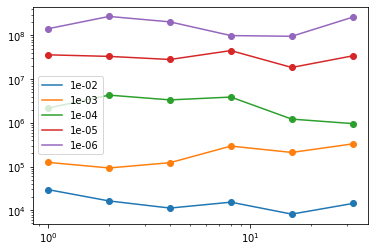

In [7]:
for i in range(len(epsilons)):
    plt.plot(2**np.arange(iae_nshots.shape[0]), iae_nshots[:,i])
    plt.scatter(2**np.arange(iae_nshots.shape[0]), iae_nshots[:,i])
        
plt.legend(['{:.0e}'.format(eps) for eps in epsilons])
plt.xscale('log')
plt.yscale('log')

plt.show()